<div align="center">
    <div><img src="../assets/redis_logo.svg" style="width: 130px"> </div>
    <div style="display: inline-block; text-align: center; margin-bottom: 10px;">
        <span style="font-size: 36px;"><b>Multi-document RAG based on LangGraph and Redis Retrieval Agent using OpenAI LLMs</b></span>
        <br />
    </div>
    <br />
</div>

In this notebook, we will utilize agents to improve upon the simple RAG application showcased in the last example (04). The key distinction with Agents is they utilize a language model to determine which steps to perform next as opposed to chains which execute the same flow regardless of input. 

Specifically we will implement a [Retrieval Agent](https://python.langchain.com/docs/use_cases/question_answering/conversational_retrieval_agents) and incorporate it into a [LangGraph](https://python.langchain.com/docs/langgraph).

To implement a Redis retrieval agent, we simply need to give an LLM access to a Redis retriever tool. By doing this the agent layer will only invoke the retriever when necessary preventing unnecessary, unrelated, and/or unwanted interactions with our financial chat tool.

## Environment Setup

In [1]:
%pip install python-dotenv


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import os
import warnings
import dotenv
# load env vars from .env file
dotenv.load_dotenv()

warnings.filterwarnings('ignore')
dir_path = os.getcwd()
parent_directory = os.path.dirname(dir_path)
sys.path.insert(0, f'{parent_directory}/helpers')
os.environ["ROOT_DIR"] = parent_directory
REDIS_URL = os.getenv("REDIS_URL")

print("========== ENVIRONMENT VARIABLES ==========")
print(f"Current Directory={dir_path}")
print(f"Parent Directory={parent_directory}")
print(f"System path={sys.path}")
print("---------------------------------")
print(f'LLM Engine: {os.getenv("LOCAL_LLM_ENGINE")}')
print(f'LOCAL_VLLM_MODEL: {os.getenv("LOCAL_VLLM_MODEL")}')
print(f'LOCAL_OLLAMA_MODEL: {os.getenv("LOCAL_OLLAMA_MODEL")}')
print(f'VLLM_URL: {os.getenv("VLLM_URL")}')
print("---------------------------------")
print(f"NLTK_DATA={os.getenv('NLTK_DATA')}")

========== ENVIRONMENT VARIABLES ==========
Current Directory=/Users/robert.shelton/Documents/financial-rag-workshop/2_RAG_patterns_with_redis
Parent Directory=/Users/robert.shelton/Documents/financial-rag-workshop
System path=['/Users/robert.shelton/Documents/financial-rag-workshop/helpers', '/Users/robert.shelton/.pyenv/versions/3.11.9/lib/python311.zip', '/Users/robert.shelton/.pyenv/versions/3.11.9/lib/python3.11', '/Users/robert.shelton/.pyenv/versions/3.11.9/lib/python3.11/lib-dynload', '', '/Users/robert.shelton/.pyenv/versions/3.11.9/lib/python3.11/site-packages']
---------------------------------
LLM Engine: ollama
LOCAL_VLLM_MODEL: meta-llama/Meta-Llama-3-8B-Instruct
LOCAL_OLLAMA_MODEL: llama3:8b
VLLM_URL: http://localhost:8000/v1
---------------------------------
NLTK_DATA=


### Install Python Dependencies

In [3]:
%pip install -r $ROOT_DIR/requirements.txt


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
from utils import *
from ingestion import *

 ✅ Loaded doc info for  110 tickers...


### Configure your Redis Stack


In [5]:
# If SSL is enabled on the endpoint, use redis:// as the URL prefix
REDIS_URL = os.getenv("REDIS_URL")

## Ingestion and Indexing

### SentenceTransformerEmbeddings Models Cache folder
We are using `SentenceTransformerEmbeddings` in this demo and here we specify the cache folder. If you already downloaded the models in a local file system, set this folder here, otherwise the library tries to download the models in this folder if not available locally.

In particular, this models will be downloaded if not present in the cache folder:

models/models--sentence-transformers--all-MiniLM-L6-v2


In [7]:
#setting the local downloaded sentence transformer models folder
os.environ["TRANSFORMERS_CACHE"] = f"{parent_directory}/models"

In [8]:
from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings

embeddings = SentenceTransformerEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2",
                                           cache_folder=os.getenv("TRANSFORMERS_CACHE", f"{parent_directory}/models"))

### Create your Redis index 
Skip this section if you have already built your index in previous notebook.


In [9]:
from redisvl.index import SearchIndex
from redisvl.schema import IndexSchema
from redis import Redis
index_name = 'langchain'
prefix = 'chunk'
schema = IndexSchema.from_yaml('sec_index.yaml')
client = Redis.from_url(REDIS_URL)
# create an index from schema and the client
index = SearchIndex(schema, client)
index.create(overwrite=True, drop=True)

### Load the sample data from SEC

In [10]:
# Skip if you have already populated your index.
sec_data = get_sec_data()

 ✅ Loaded doc info for  110 tickers...


### Ingest the data for the selected tickers

In [11]:
redis_bulk_upload(sec_data, index, embeddings, tickers=['AAPL', 'AMZN'])

✅ Loaded 632 10K chunks for ticker=AAPL from AAPL-2021-10K.pdf
✅ Loaded 561 10K chunks for ticker=AAPL from AAPL-2023-10K.pdf
✅ Loaded 608 10K chunks for ticker=AAPL from AAPL-2022-10K.pdf
✅ Loaded 130 earning_call chunks for ticker=AAPL from 2018-May-01-AAPL.txt
✅ Loaded 158 earning_call chunks for ticker=AAPL from 2019-Oct-30-AAPL.txt
✅ Loaded 164 earning_call chunks for ticker=AAPL from 2016-Jan-26-AAPL.txt
✅ Loaded 167 earning_call chunks for ticker=AAPL from 2020-Jul-30-AAPL.txt
✅ Loaded 151 earning_call chunks for ticker=AAPL from 2017-Aug-01-AAPL.txt
✅ Loaded 146 earning_call chunks for ticker=AAPL from 2020-Jan-28-AAPL.txt
✅ Loaded 163 earning_call chunks for ticker=AAPL from 2016-Apr-26-AAPL.txt
✅ Loaded 149 earning_call chunks for ticker=AAPL from 2017-Jan-31-AAPL.txt
✅ Loaded 149 earning_call chunks for ticker=AAPL from 2019-Apr-30-AAPL.txt
✅ Loaded 123 earning_call chunks for ticker=AAPL from 2017-Nov-02-AAPL.txt
✅ Loaded 151 earning_call chunks for ticker=AAPL from 2016-Oc

## Redis as a Langchain Retriever

In [12]:
from langchain_community.vectorstores import Redis as LangChainRedis

index_name = 'langchain'

vec_schema , main_schema = create_langchain_schemas_from_redis_schema('sec_index.yaml')

rds = LangChainRedis.from_existing_index( embedding = embeddings, 
                                          index_name = index_name, 
                                          schema = main_schema)
redis_retriever = rds.as_retriever()


Test if the Redis index is working and returning relevant document.

In [13]:
rds.similarity_search(query="Revenue of Apple in 2022", k=4, distance_threshold=0.8)

[Document(page_content='The year-over-year growth in selling, general and administrative expense in 2022 was driven primarily by increases in headcount- related expenses, advertising and professional services.\n\nApple Inc. | 2022 Form 10-K | 23\n\n2020\n\n69,461 35,495 104,956\n\n31.5 % 66.0 % 38.2 %\n\n2020 18,752\n\n7 %\n\n19,916\n\n7 %\n\n38,668\n\n14 %\n\nOther Income/(Expense), Net\n\nOther income/(expense), net (“OI&E”) for 2022, 2021 and 2020 was as follows (dollars in millions):\n\n2022\n\nChange\n\n2021\n\nChange', metadata={'id': 'chunk:AAPL-2022-10K.pdf-3020eb5d-eacc-400c-b1a0-158bacf6c482', 'chunk_id': 'AAPL-2022-10K.pdf-3020eb5d-eacc-400c-b1a0-158bacf6c482', 'source_doc': 'AAPL-2022-10K.pdf', 'doc_type': '10K', 'ticker': 'AAPL', 'company_name': 'APPLE INC', 'sector': 'Information Technology', 'asset_class': 'Equity', 'location': 'United States', 'exchange': 'NASDAQ', 'currency': 'USD', 'market_value': '559365151.11', 'weight': '5.16', 'notional_value': '559365151.11', 'sh

Now we create a Langchain Redis retriever tool.

In [14]:
from langchain.tools.retriever import create_retriever_tool

redis_retriever_tool = create_retriever_tool(
    redis_retriever,
    "retrieve_10K-filings",
    "Search and return information about financials of companies reported in 10K filings",
)

tools = [redis_retriever_tool]

from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tools)

## Agent state

For use in the LangGraph we define a `state` object as a list of `messages` that each node in our graph will be passed and can append to.


In [15]:
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

## Nodes and Edges

We can lay out an agentic RAG graph like this:

* The state is a set of messages
* Each node will update (append to) state
* Conditional edges decide which node to visit next

![diagram1.png](diagram1.png)

## Define the tools, edges, and nodes to be utilized

In [17]:
from typing import Annotated, Literal, Sequence, TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import tools_condition
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate, HumanMessagePromptTemplate
# LangChain supports many other chat models. Here, we're using Ollama
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

# supports many more optional parameters. Hover on your `ChatOllama(...)`
# class to view the latest available supported parameters


### Edges


def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    local_prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = local_prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content
    
    print(docs)

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


### Nodes


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4-turbo")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    # Prompt
    #prompt = hub.pull("rlm/rag-prompt")
    local_prompt = ChatPromptTemplate(
        input_variables=['context', 'question'], 
        messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))])

    # LLM
    llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = local_prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


## Graph

The following defines the execution graph. Note that we add notes for each step in our process summarized by the diagram below.

In [18]:
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([redis_retriever_tool])
workflow.add_node("redis_retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.set_entry_point("agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "redis_retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "redis_retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

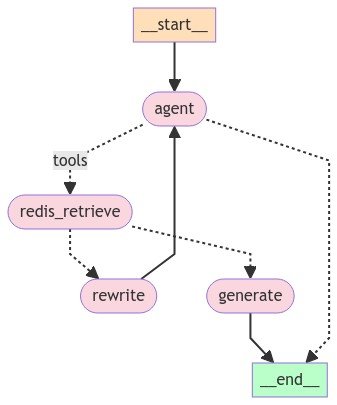

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

## Let's test it out!

First let's start by asking an unrelated question to our financial chat application.

In [26]:
import pprint

inputs = {
    "messages": [
        ("user", "How do you feel today?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"{key=}")
        pprint.pprint(f"{value=}")

---CALL AGENT---
"key='agent'"
('value={\'messages\': [AIMessage(content="I don\'t have feelings, but I\'m '
 'here to help you! How can I assist you today?", '
 "response_metadata={'finish_reason': 'stop', 'model_name': "
 "'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_0993c4a4c0'}, "
 "id='run-1f6191fd-8834-4fc7-b822-2067e97b61d6-0')]}")


#### In the case of irrelevant question, only the agent layer of our graph was invoked because it determined no other steps were necessary.

Now let's ask it a relevant question

In [28]:
import pprint

inputs = {
    "messages": [
        ("user", "What was the performance of Apple revenue in 2022?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"{key=}")
        pprint.pprint(f"{value=}")

---CALL AGENT---


score_threshold is deprecated. Use distance_threshold instead.score_threshold should only be used in similarity_search_with_relevance_scores.score_threshold will be removed in a future release.


"key='agent'"
("value={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': "
 "[{'index': 0, 'id': 'call_Csi00GQ4Y59mPrZaDL9ncT0E', 'function': "
 '{\'arguments\': \'{"query":"Apple revenue 2022"}\', \'name\': '
 "'retrieve_10K-filings'}, 'type': 'function'}]}, "
 "response_metadata={'finish_reason': 'tool_calls', 'model_name': "
 "'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_0993c4a4c0'}, "
 "id='run-f7b5ae05-d06e-458e-873e-5ec9027079fa-0', tool_calls=[{'name': "
 "'retrieve_10K-filings', 'args': {'query': 'Apple revenue 2022'}, 'id': "
 "'call_Csi00GQ4Y59mPrZaDL9ncT0E'}])]}")
---CHECK RELEVANCE---
The year-over-year growth in selling, general and administrative expense in 2022 was driven primarily by increases in headcount- related expenses, advertising and professional services.

Apple Inc. | 2022 Form 10-K | 23

2020

69,461 35,495 104,956

31.5 % 66.0 % 38.2 %

2020 18,752

7 %

19,916

7 %

38,668

14 %

Other Income/(Expense), Net

Other income/(expense), 

## What just happened?

Admittedly the output is large and hard to read but if we investigate we can see that the agent determined the question was valid, invoked the redis_retrieval tool to get the correct context to answer the question, and generated an answer accordingly. 

In [29]:
output

{'generate': {'messages': ["Selling, general and administrative expense was relatively flat in 2023 compared to 2022. Apple's revenue performance in 2022 is not explicitly mentioned in the provided context."]}}